## Introduction

If you are an investor in stocks or bonds you are likely always looking for ways to increase your return or lower your risk, and it turns out there is a way to do both simultaneously called rebalancing. Portfolio rebalancing is something every investor should either do themselves or have done for them. Registered investment advisors like Vanguard and others will provide this service as part of an active management agreement, while robo-advisors such as Betterment will also rebalance automatically. To understand why it's so important, I'll defer to the finance professionals over at [BogleHeads](https://www.bogleheads.org/wiki/Rebalancing) :

>Rebalancing is the action of bringing a portfolio that has deviated away from one's target asset allocation back into line. The objective is to maintain a consistent mix of asset classes (most commonly equities vs. fixed income) in order to control risk at the level desired by the investor. This is accomplished by transferring funds from higher-performing classes to lower-performing classes. While potentially counterintuitive, rebalancing ensures that investors "Buy Low" and "Sell High".

Much research has been conducted on the benefits of portoflio rebalancing, here is an excerpt from a fairly recent [Morgan Stanley](https://www.morganstanley.com/articles/rebalancing-effect) research piece:

>Rebalancing takes advantage of the long-term effects of mean reversion. By lightening up on stocks after periods of significant outperformance, or topping off positions after periods of underperformance, this discipline helps take advantage of volatility to benefit from these swings. ... A disciplined approach to rebalancing portfolios annually can create additional return and lower volatility versus never rebalancing or rebalancing during different time periods. While investing for the long term requires patience, a disciplined approach to rebalancing can help create value beyond the cyclical trends of the market.

Timely and consistent rebalancing has become a cornerstone of modern portfolio theory. Rebalancing can magnify returns by promoting selling high and buying low, and reduce long-term risk by ensuring the portfolio adheres to its designated risk tolerance. The keys are to rebalance in a timely manner (i.e. annually) and to do it consistently because the benefits of rebalancing compound over time - but rebalancing by hand is a pain, and that can lead to inconsistency. I pursued this project due to the lack of free tools to simply rebalance an existing portfolio. Sure, we can all use a worksheet to do the math each time, but why not automate it and make it more likely we will actually do it? Here, inspired by the work of [kdboller](https://nbviewer.jupyter.org/github/kdboller/pythonsp500/blob/a7066d998ff046c3cc8b26ece3b0efdf00959d57/Investment%20Portfolio%20Python%20Notebook_03_2018_blog%20example.ipynb), I'll use Pandas, the Tiingo API, and some simple math to calculate how to optimally rebalance a portfolio given a target allocation. This is a simple, no-frills portfolio rebalancing exercise which does not factor in important considerations such as tax efficiency, transaction costs, or alternate approaches such as stock-out rebalances, or bond-floor settings. Future versions of this project may contemplate these extra factors.  


**Steps:** 
1. Set triggers to rebalance (time or threshold or both)
2. Define our current Portfolio (accounttype, accountid, lastrebaldate, ticker, shares, cost basis, assetclass)  
3. Define our target allocation (ticker, allocation, assetclass)  
4. Factor in any new money being invested  
5. Calculate rebalance triggers and determine which securities must be rebalanced
6. Calculate initial transactions needed to hit target allocation (1 row per ticker)
7. Disaggregate portfolio back to account level (1 row per ticker per account)
8. Iteratively distribute new securities into accounts, keeping tax location in mind
9. Iteratively distribute across accounts any new securities which do not fit into a single account


**References:**

[pythonsp500 by kdboller](https://nbviewer.jupyter.org/github/kdboller/pythonsp500/blob/a7066d998ff046c3cc8b26ece3b0efdf00959d57/Investment%20Portfolio%20Python%20Notebook_03_2018_blog%20example.ipynb)

[Portfolio Rebalancing by bogleheads wiki](https://www.bogleheads.org/wiki/Rebalancing)

[The Rebalancing Effect by Morgan Stanely](https://www.morganstanley.com/articles/rebalancing-effect)  



**Github Repo:**
[pogoetic/rebalance](https://github.com/pogoetic/rebalance)

## Code

In [50]:
#Lets import the necessary packages
import pandas as pd
from IPython.display import display
pd.set_option('display.max_columns', None)
import numpy as np
import datetime
import decimal
from pandas_datareader import data as pdr
from keys import tiingo_key
#define todays datetime
now = datetime.datetime.now()

In [51]:
#Settings
new_money_in = 10000
#Set our rebalance threshold
rebal_threshold = .05 #allowable allocation drift
rebal_timeframe = 180 #in days

In [52]:
#Define target and current allocations
#create our target allocation
columns_t = ['ticker','allocation_target','assetclass']
positions_t = [['VTSAX',0.5652,'ST'],
               ['VIGAX',0.0131,'ST'],
               ['VSMAX',0.0066,'ST'],
               ['VSEQX',0.0066,'ST'],
               ['VWIGX',0.0507,'ST'],
               ['VTRIX',0.0507,'ST'],
               ['VTIAX',0.1521,'ST'],
               ['VBTLX',0.035,'BD'],
               ['VTABX',0.015,'BD'],
               ['VGSLX',0.05,'RE'],
               ['VNQI',0.01,'RE'],
               ['VDE',0.03,'ST'],
               ['GLD',0.015,'CS']]

#set our current portfolio
columns_c = ['accounttype','accountid','lastrebaldate','ticker','assetclass','basisdate','costbasis','shares']
positions_c = [['RIRA','1111','2018-11-16','VBTLX','BD','2018-11-16',1,913.483],
             ['RIRA','1111','2018-11-16','VTIAX','ST','2018-11-16',1,514.298],
             ['RIRA','1111','2018-11-16','VTSAX','ST','2018-11-16',10,151.121],
             ['RIRA','2222','2018-11-16','VBTLX','BD','2018-11-16',1,772.407],
             ['RIRA','2222','2018-11-16','VTSAX','ST','2018-11-16',20,151.578],
             ['TAXB','3333','2018-11-16','AAPL','ST','2018-11-16',1,3.14],
             ['TAXB','3333','2018-11-16','VTSAX','ST','2018-11-16',10,549.871]]

In [53]:
#lookup table for account type abbreviations
accounttypes = {'TAXB':'Taxable Brokerage', '401K':'401k', 'RIRA':'Roth-IRA', 'TIRA':'Traditional-IRA'}
assetclasses = {'ST':'Equity Stocks', 'BD':'Bonds Fixed-Income', 'CS':'Cash and Commodities', 'RE':'Real-Estate', 'ALT':'Alternatives'}
assettypes = {'SEC':'Individual Security', 'ETF':'Exchange Traded Fund', 'MF': 'Mutual Fund', 'IF':'Index Fund'}
assetregion = {'D':'Domestic','I':'International'}

#initialize target portfolio
targetalloc = pd.DataFrame(columns = columns_t, data = positions_t)
total=decimal.Decimal(targetalloc.allocation_target.sum())
#check that our target allocation indeed adds to 100%
assert round(total,4) == 1,'Target Allocation not 100% : {}'.format(int(total))

#initialize current portfolio
start_port = pd.DataFrame(columns = columns_c, data = positions_c)
start_port.lastrebaldate = pd.to_datetime(start_port.lastrebaldate)
start_port.basisdate = pd.to_datetime(start_port.basisdate)

#custom apply function
def f(x):
    d = {}
    d['lastrebaldate'] = x['lastrebaldate'].max()
    d['assetclass'] = x['assetclass'].max()
    d['basisdate'] = x['basisdate'].min()
    d['costbasis'] = (x['costbasis'] * x['shares']).sum()/(x['shares'].sum() or 1) #weighted avg
    d['shares'] = x['shares'].sum()
    return pd.Series(d, index=['lastrebaldate', 'assetclass', 'basisdate', 'costbasis', 'shares'])

#aggregate by ticker to account for duplicate securities held in different accounts
agg_port = start_port.groupby(['ticker']).apply(f)

#Define list of distinct tickers we care about
tickers = set(targetalloc.ticker.unique().tolist()+start_port.ticker.unique().tolist())

In [70]:
#Lets look at our input portfolios (target and current)
display(targetalloc)
display(start_port)

#And our aggregated portfolio at the ticker level (1 row per ticker)
display(agg_port)

,ticker,allocation_target,assetclass
0,VTSAX,0.5652,ST
1,VIGAX,0.0131,ST
2,VSMAX,0.0066,ST
3,VSEQX,0.0066,ST
4,VWIGX,0.0507,ST
5,VTRIX,0.0507,ST
6,VTIAX,0.1521,ST
7,VBTLX,0.0350,BD
8,VTABX,0.0150,BD
9,VGSLX,0.0500,RE


,accounttype,accountid,lastrebaldate,ticker,assetclass,basisdate,costbasis,shares
0,RIRA,1111,2018-11-16,VBTLX,BD,2018-11-16,1,913.483
1,RIRA,1111,2018-11-16,VTIAX,ST,2018-11-16,1,514.298
2,RIRA,1111,2018-11-16,VTSAX,ST,2018-11-16,10,151.121
3,RIRA,2222,2018-11-16,VBTLX,BD,2018-11-16,1,772.407
4,RIRA,2222,2018-11-16,VTSAX,ST,2018-11-16,20,151.578
5,TAXB,3333,2018-11-16,AAPL,ST,2018-11-16,1,3.140
6,TAXB,3333,2018-11-16,VTSAX,ST,2018-11-16,10,549.871


,lastrebaldate,assetclass,basisdate,costbasis,shares
ticker,,,,,
AAPL,2018-11-16,ST,2018-11-16,1.000000,3.140
VBTLX,2018-11-16,BD,2018-11-16,1.000000,1685.890
VTIAX,2018-11-16,ST,2018-11-16,1.000000,514.298
VTSAX,2018-11-16,ST,2018-11-16,11.777895,852.570


In [23]:
#Next we pull the latest prices from Tiingo (YahooFinance is buggy, and IEX does not contain mutual fund data)
#Tiingo limits for free API: 500 unique tickers ever, 500 requests/hr, 20,000 requests/day
#https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#tiingo
#Tiingo API key required: set 'tiingo_key' value in python file called 'keys.py' in same directory as this script
now = datetime.datetime.now()
yesterday = now - datetime.timedelta(3) #avoids weekends with no data - need better weekend detection
start = datetime.datetime(yesterday.year, yesterday.month, yesterday.day)
end = datetime.datetime(now.year, now.month, now.day)

bad_tickers = []
for i, t in enumerate(tickers):
    try:
        if i==0:
            ohlc = pdr.get_data_tiingo(t, api_key=tiingo_key).tail(1).close
        else:
            ohlc = ohlc.append(pdr.get_data_tiingo(t, api_key=tiingo_key).tail(1).close)
    except:
        bad_tickers.append(t)
        
#print(bad_tickers)
ohlc = ohlc.to_frame(name='close')

#drop our date index since its only the latest data
ohlc2=ohlc.reset_index(level=1, drop=True)

#Manual fix for known bad_tickers which Tiingo can't find, adjust to suit your needs
if 'VMFXX' in bad_tickers:
    ohlc2.loc['VMFXX'] = 1.0

In [71]:
#What did we get?
display(ohlc2)

,close
symbol,
VSEQX,25.38
VBTLX,10.43
VWIGX,23.91
VDE,72.37
VIGAX,64.33
VGSLX,101.55
VTIAX,24.62
VTRIX,31.15
VSMAX,59.33


In [54]:
#concatenate target allocation and latest prices with our portfolio
start_port_c = pd.merge(agg_port, targetalloc, on ='ticker', how ='outer')
final_port = pd.merge(start_port_c, ohlc2, left_on ='ticker', right_index = True, how = 'left')

#set target to zero for tickers held but not present in our target allocation, set initial basisdate and costbasis for new securities entering the portfolio
final_port.fillna(value = {'allocation_target':0.0,'shares':0.0,'basisdate':pd.to_datetime(now.strftime("%Y-%m-%d")),'costbasis':final_port.close,'assetclass_x':final_port.assetclass_y},inplace = True)
final_port.drop(['assetclass_y'],axis=1,inplace=True)
final_port.rename(columns={'assetclass_x':'assetclass'},inplace=True)

#calculate holding values and current allocation
final_port['value'] = final_port.close * final_port.shares #calculate value as price x shares
final_port.loc[final_port.value.isna() & final_port.shares.isna(),['value']]=0.0 #for securities not currently held but in our target (and close price failed to return), establish zero value
final_port['allocation'] = final_port.value / final_port.value.sum()
final_port['correction'] = final_port.allocation_target - final_port.allocation
final_port['new_money_in'] = new_money_in * final_port.allocation_target #Account for new money in

In [55]:
#create timedelta int column
final_port['timedelta'] = (final_port.lastrebaldate - pd.to_datetime(now.strftime("%Y-%m-%d"))).dt.days
final_port.timedelta.fillna(0,inplace=True)

#define rebalance flags to determine if we must rebalance
final_port['rebal_flag_thresh'] = np.where((abs(final_port.correction)<=rebal_threshold) & (final_port.allocation > 0),0,1)
final_port['rebal_flag_time'] = np.where(final_port.timedelta >= rebal_timeframe,1,0)
final_port['rebal_flag_exit'] = np.where((final_port.allocation > 0) & (final_port.allocation_target==0),1,0) #force rebal securities not present in our target portfolio
final_port['rebal_flag_newmoney'] = np.where(final_port.new_money_in>0,1,0)
final_port['rebal_flag'] = np.where(final_port.rebal_flag_thresh + final_port.rebal_flag_time + final_port.rebal_flag_exit + final_port.rebal_flag_newmoney >= 1,1,0)

#Subset of securities we need to rebalance, and those we need to leave alone
rebal_port = final_port[final_port.rebal_flag==1].copy()
stable_port = final_port[final_port.rebal_flag==0].copy()

In [56]:
#Calculate our current allocation, target, and the change we need to hit target
total_val = rebal_port.value.sum()
rebal_port['allocation'] = rebal_port.value/rebal_port.value.sum()
rebal_port['allocation_target'] = rebal_port.allocation_target/rebal_port.allocation_target.sum()
rebal_port['correction'] = rebal_port.allocation_target - rebal_port.allocation

#Factor in any new money entering the portfolio and determine necessary changes in value and shares
rebal_port['value_chg'] = (total_val * rebal_port.correction) + rebal_port.new_money_in
rebal_port['shares_chg'] = rebal_port.value_chg / rebal_port.close
rebal_port.loc[rebal_port.value_chg.isna() & rebal_port.shares > 0,['shares_chg']]=-rebal_port.shares #sell all shares of securities not in our target portfolio

#Round off shares to whole numbers, except when we are fully exiting a position
rebal_port['shares_chg_round'] = rebal_port.shares_chg
rebal_port = rebal_port.astype({'shares_chg_round': int})
rebal_port['final_shares_chg'] = rebal_port.shares_chg
rebal_port.loc[np.round(rebal_port.shares_chg+rebal_port.shares)!=0,['final_shares_chg']]=rebal_port.shares_chg_round*1.0
rebal_port.drop(['shares_chg_round'],axis=1,inplace=True)

#Calculate initial new shares and values
rebal_port['new_shares'] = np.round(rebal_port.shares + rebal_port.final_shares_chg,3)
rebal_port['new_value'] = rebal_port.new_shares * rebal_port.close #due to share rounding, there will be slight variance vs. portfolio starting value
rebal_port['new_value_chg'] = rebal_port.final_shares_chg * rebal_port.close

In [57]:
#Double check our work so far
#net of buying and selling should be zero
assert(np.round(rebal_port.value_chg.sum(),3)-new_money_in==0) 
#make sure totals match (with rounding error + new money in) from original portfolio and rebalanced portfolio
assert(np.round(rebal_port.new_value.sum() - rebal_port.value.sum(),3)==np.round((rebal_port.new_value.sum() + stable_port.value.sum()) - final_port.value.sum(),3))

In [58]:
#Merge our rebalanced portfolio with our stable portfolio for our execution portfolio
stable_port['value_chg'] = 0
stable_port['shares_chg']=0
stable_port['final_shares_chg'] = 0
stable_port['new_value_chg'] = 0
stable_port['new_shares'] = stable_port.shares
stable_port['new_value'] = stable_port.value
exec_port = pd.concat([rebal_port,stable_port],sort=False)
exec_port.drop(columns=['timedelta','rebal_flag_thresh','rebal_flag_time','rebal_flag_exit','rebal_flag_newmoney','value_chg','shares_chg'],inplace=True)

#Reset allocations to be based on all securities
exec_port['allocation'] = exec_port.value/exec_port.value.sum()
exec_port['allocation_target'] = exec_port.allocation_target/exec_port.allocation_target.sum()
exec_port['correction'] = exec_port.allocation_target - exec_port.allocation
exec_port['final_allocation'] = exec_port.new_value / exec_port.new_value.sum()

In [59]:
#Lets look at all our work to get to our target portfolio
exec_port

,ticker,lastrebaldate,assetclass,basisdate,costbasis,shares,allocation_target,close,value,allocation,correction,new_money_in,rebal_flag,final_shares_chg,new_shares,new_value,new_value_chg,final_allocation
0,AAPL,2018-11-16,ST,2018-11-16,1.000000,3.140,0.0000,146.83,461.04620,0.005740,-0.005740,0.0,1,-3.14,0.000,0.00000,-461.0462,0.000000
1,VBTLX,2018-11-16,BD,2018-11-16,1.000000,1685.890,0.0350,10.43,17583.83270,0.218928,-0.183928,350.0,1,-1382.00,303.890,3169.57270,-14414.2600,0.035195
2,VTIAX,2018-11-16,ST,2018-11-16,1.000000,514.298,0.1521,24.62,12662.01676,0.157649,-0.005549,1521.0,1,43.00,557.298,13720.67676,1058.6600,0.152353
3,VTSAX,2018-11-16,ST,2018-11-16,11.777895,852.570,0.5652,58.19,49611.04830,0.617683,-0.052483,5652.0,1,24.00,876.570,51007.60830,1396.5600,0.566385
4,VIGAX,NaT,ST,2018-12-25,64.330000,0.000,0.0131,64.33,0.00000,0.000000,0.013100,131.0,1,18.00,18.000,1157.94000,1157.9400,0.012858
5,VSMAX,NaT,ST,2018-12-25,59.330000,0.000,0.0066,59.33,0.00000,0.000000,0.006600,66.0,1,10.00,10.000,593.30000,593.3000,0.006588
6,VSEQX,NaT,ST,2018-12-25,25.380000,0.000,0.0066,25.38,0.00000,0.000000,0.006600,66.0,1,23.00,23.000,583.74000,583.7400,0.006482
7,VWIGX,NaT,ST,2018-12-25,23.910000,0.000,0.0507,23.91,0.00000,0.000000,0.050700,507.0,1,191.00,191.000,4566.81000,4566.8100,0.050710
8,VTRIX,NaT,ST,2018-12-25,31.150000,0.000,0.0507,31.15,0.00000,0.000000,0.050700,507.0,1,147.00,147.000,4579.05000,4579.0500,0.050845
9,VTABX,NaT,BD,2018-12-25,21.650000,0.000,0.0150,21.65,0.00000,0.000000,0.015000,150.0,1,62.00,62.000,1342.30000,1342.3000,0.014905


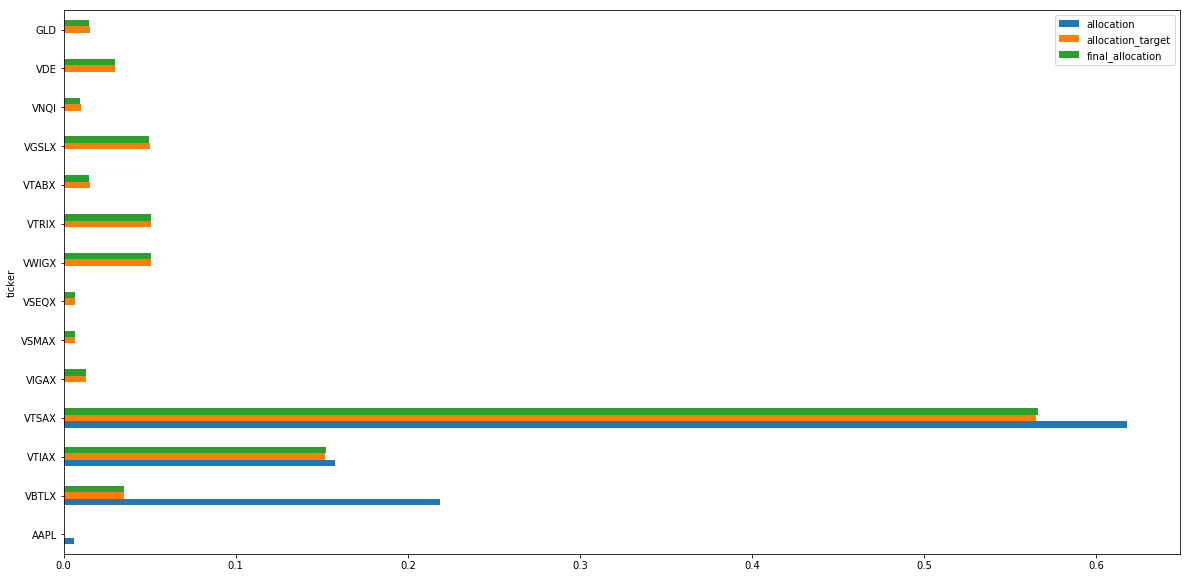

In [60]:
#Lets add a bar chart here to show the new allocation vs. the target allocation and vs. the original portfolio
graph_port = exec_port[['ticker','allocation','allocation_target','final_allocation']].copy()
graph_port.plot.barh(x='ticker',figsize=(20,10))

In [61]:
#Next we turn our ticker-level strategy into account level actions
#Join in our rebalanced portfolio and determine how to split value across accounts for a given ticker
port = pd.merge(start_port[['accounttype','accountid','ticker','shares']], 
                   exec_port[['ticker','assetclass','close','value','final_shares_chg','new_shares','new_value','new_value_chg','final_allocation']], 
                   how = 'right', 
                   left_on = 'ticker', 
                   right_on = 'ticker')
port['value_orig'] = port.close * port.shares
#Calculate the value-weight of each ticker by account
port['tick_alloc'] = port.value_orig / port.value #What pct of each ticker is in a given account?
port['tick_alloc'].fillna(1.0,inplace=True)
#check our sub-allocations
assert(port.groupby('ticker').tick_alloc.sum().sum() == len(port.groupby('ticker').tick_alloc.sum()))

#port.fillna({'assetclass_x':final_port.assetclass_y})

#Recalculate the values proportionately
port['final_shares_chg'] = port.final_shares_chg * port.tick_alloc
port['new_shares'] = port.new_shares * port.tick_alloc
port['new_value'] = port.new_value * port.tick_alloc
port['new_value_chg'] = port.new_value_chg * port.tick_alloc
port['final_allocation'] = port.final_allocation * port.tick_alloc
port['value'] = port.value * port.tick_alloc
port.drop(['value_orig','tick_alloc'],axis=1,inplace=True)

#double check our final_allocation is 100%
assert(np.round(port.final_allocation.sum(),4)==1.0)

#Lets look at our final portfolio at the account level
port

,accounttype,accountid,ticker,shares,assetclass,close,value,final_shares_chg,new_shares,new_value,new_value_chg,final_allocation
0,RIRA,1111,VBTLX,913.483,BD,10.43,9527.62769,-748.823177,164.659823,1717.401953,-7810.225737,0.019070
1,RIRA,2222,VBTLX,772.407,BD,10.43,8056.20501,-633.176823,139.230177,1452.170747,-6604.034263,0.016125
2,RIRA,1111,VTIAX,514.298,ST,24.62,12662.01676,43.000000,557.298000,13720.676760,1058.660000,0.152353
3,RIRA,1111,VTSAX,151.121,ST,58.19,8793.73099,4.254084,155.375084,9041.276111,247.545121,0.100394
4,RIRA,2222,VTSAX,151.578,ST,58.19,8820.32382,4.266948,155.844948,9068.617534,248.293714,0.100697
5,TAXB,3333,VTSAX,549.871,ST,58.19,31996.99349,15.478968,565.349968,32897.714655,900.721165,0.365294
6,TAXB,3333,AAPL,3.140,ST,146.83,461.04620,-3.140000,0.000000,0.000000,-461.046200,0.000000
7,NaN,NaN,VIGAX,NaN,ST,64.33,0.00000,18.000000,18.000000,1157.940000,1157.940000,0.012858
8,NaN,NaN,VSMAX,NaN,ST,59.33,0.00000,10.000000,10.000000,593.300000,593.300000,0.006588
9,NaN,NaN,VSEQX,NaN,ST,25.38,0.00000,23.000000,23.000000,583.740000,583.740000,0.006482


In [67]:
#Finally, all new tickers need an account to land in
dport = None
acctsdf = None
if len(port[port.accounttype.isnull()])>0: #if we have none, skip this step
    print('Distributing new securities to existing accounts . . .')
    dport = port.copy()

    #account-level fund surplus or deficit - must match these with our orphaned securities
    accts = []
    for i in list(zip(port.groupby(['accountid','accounttype']).new_value_chg.sum().index.values,port.groupby(['accountid','accounttype']).new_value_chg.sum().values)):
        accts.append([i[0][0],i[0][1],i[1]])
    acctsdf = pd.DataFrame(data=accts,columns=['accountid','accounttype','new_value_chg_sum'])
    #establish sort order so we can allocate tax-efficient account space first
    actype_sortorder = pd.DataFrame(data=[['RIRA',1],['TIRA',2],['TAXB',3]],columns=['accounttype','order'])
    acctsdf = pd.merge(acctsdf,actype_sortorder,how='left',left_on='accounttype',right_on='accounttype')
    #We make a consequential assumption here that any new_money_in will be allocated 100% in one of the Taxable accounts (first in list).
    #if you have a Roth-IRA which has not met its contribution limits for the year, it may be preferrential to distribute the funds there first.
    #IF YOU HAVE NO TAXABLE ACCOUNT AND YOU WISH TO REBALANCE WITH new_money_in > 0 this will cause errors - so we assert here:
    assert(new_money_in == 0 or (len(acctsdf[acctsdf.accounttype == 'TAXB'])>0 and new_money_in > 0))
    min_idx = acctsdf[acctsdf.accounttype == 'TAXB'].index.min()
    acctsdf.loc[min_idx,'new_value_chg_sum'] = acctsdf.loc[min_idx,'new_value_chg_sum'] - new_money_in
    #only return accounts that have space
    acctsdf = acctsdf[acctsdf.new_value_chg_sum<0].copy()

    #establish sort order so we can allocate tax-inefficient assets first
    aclass_sortorder = pd.DataFrame(data=[['ST',3],['BD',1],['CS',4],['RE',2],['ALT',5]],columns=['assetclass','order'])
    dport = pd.merge(dport,aclass_sortorder,how='left',left_on='assetclass',right_on='assetclass')

    #We loop twice, first to fit whole securities in accounts with tax location in mind, then again without tax location for anything leftover
    loop = 0
    while loop < 2:
        loop+=1
        #loop through orphaned tickers and place them in accounts until all assets are allocated or we are forced to split a security across accounts
        #  in the first loop we do not allow tax-inefficient assets to wind up in Taxable accounts, in the second loop we relax this constraint
        for index, row in dport[dport.accounttype.isnull()].sort_values(['order','new_value_chg'],ascending=[True,False]).iterrows():
            #loop through accounts and place the assets
            for i, r in acctsdf.iterrows():
                aid = r.accountid
                atype = r.accounttype
                bal = r.new_value_chg_sum
                #print('Evaluating {}-{} with {} starting bal'.format(aid,atype,bal))
                if loop == 0 and (row.assetclass in ('BD','RE') and atype == 'TAXB'):
                    continue #skip this case, since we don't want to place Bonds and Real-Estate assets in Taxable accounts
                elif loop == 0 and (row.assetclass not in ('BD','RE') and atype != 'TAXB'):
                    continue #skip this case, since we don't want to place tax-efficient assets into tax sheltered accounts 

                if row.new_value_chg + bal <=0: #it fits
                    bal+=row.new_value_chg
                    print(' FITS {} in {}-{} with {} remaining'.format(row.ticker,aid,atype,bal))
                    #update our portfolio
                    dport.loc[index,'accountid'] = aid
                    dport.loc[index,'accounttype'] = atype
                    #update account bal for next loop
                    acctsdf.loc[i,'new_value_chg_sum'] = bal
                    break
                else:
                    print(' {} {} does not fit in {}-{}'.format(row.ticker,row.new_value_chg,aid,atype))
    
    print('\nLets see what remains in our accounts after 2 loops . . .')
    display(acctsdf)
                    
    #Here we are forced to split a security across multiple accounts because no one account can fit it
    #  in this loop we allow tax-inefficient assets to wind up in Taxable accounts, but only as a last resort
    if len(dport[dport.accounttype.isnull()])>0:
        print('Splitting remaining securities across accounts . . .')
        #loop through accounts and place portions of asset in each, create a new row in the df for each placement.
        for index, row in dport[dport.accounttype.isnull()].sort_values(['order','new_value_chg'],ascending=[True,False]).iterrows():
            final_shares_chg = row.final_shares_chg
            new_value_chg = row.new_value_chg
            #if its a tax-inefficent asset, order the accounts by 'order'
            if row.assetclass in ('BD','RE'):
                acctsdf = acctsdf.sort_values('order',ascending=True)
            else:
                acctsdf = acctsdf.sort_values('order',ascending=False)
                
            for i, r in acctsdf.iterrows():
                bal = r.new_value_chg_sum
                pct_move = -bal/row.new_value_chg
                new_value_chg+=bal
                print(' {} move {} or {}% into account {}-{}. {} bal remaining {}'.format(row.ticker,-bal,pct_move,r.accountid,r.accounttype,row.ticker,new_value_chg))
                
                #update our account to reflect this change
                if new_value_chg > 0:
                    acctsdf.loc[i,'new_value_chg_sum'] = 0.0
                else:
                    acctsdf.loc[i,'new_value_chg_sum'] = new_value_chg
                    
                #create new row in our portfolio for this asset in this account
                dport.loc[max(dport.index)+1] = [r.accounttype,
                                        r.accountid,
                                        row.ticker,
                                        row.shares,
                                        row.assetclass,
                                        row.close,
                                        row.value,
                                        np.floor(pct_move*row.final_shares_chg), #we round down to get back to whole shares
                                        np.floor(pct_move*row.new_shares),
                                        np.floor(pct_move*row.new_shares)*row.close,
                                        (np.floor(pct_move*row.new_shares)*row.close)-row.value,
                                        np.floor(pct_move*row.new_value)/dport.new_value.sum(),
                                        row.order]
                
                #finally delete the original row from the df
                dport.drop(dport[dport.accounttype.isnull()].index,inplace=True)

Distributing new securities to existing accounts . . .
 FITS VTABX in 1111-RIRA with -5161.720615958396 remaining
 FITS VGSLX in 1111-RIRA with -693.5206159583959 remaining
 VNQI 871.08 does not fit in 1111-RIRA
 FITS VNQI in 2222-RIRA with -5484.660549177605 remaining
 VTRIX 4579.05 does not fit in 1111-RIRA
 FITS VTRIX in 2222-RIRA with -905.6105491776052 remaining
 VWIGX 4566.81 does not fit in 1111-RIRA
 VWIGX 4566.81 does not fit in 2222-RIRA
 FITS VWIGX in 3333-TAXB with -4993.515034863999 remaining
 VDE 2677.69 does not fit in 1111-RIRA
 VDE 2677.69 does not fit in 2222-RIRA
 FITS VDE in 3333-TAXB with -2315.825034863999 remaining
 VIGAX 1157.94 does not fit in 1111-RIRA
 VIGAX 1157.94 does not fit in 2222-RIRA
 FITS VIGAX in 3333-TAXB with -1157.885034863999 remaining
 FITS VSMAX in 1111-RIRA with -100.22061595839591 remaining
 VSEQX 583.74 does not fit in 1111-RIRA
 FITS VSEQX in 2222-RIRA with -321.8705491776052 remaining
 GLD 1320.22 does not fit in 1111-RIRA
 GLD 1320.22 do

,accountid,accounttype,new_value_chg_sum,order
0,1111,RIRA,-100.220616,1
1,2222,RIRA,-321.870549,1
2,3333,TAXB,-1157.885035,3


Splitting remaining securities across accounts . . .
 GLD move 1157.885034863999 or 0.8770394592295215% into account 3333-TAXB. GLD bal remaining 162.33496513600107
 GLD move 100.22061595839591 or 0.07591205704988252% into account 1111-RIRA. GLD bal remaining 62.11434917760516
 GLD move 321.8705491776052 or 0.24380069168593507% into account 2222-RIRA. GLD bal remaining -259.75620000000004


In [68]:
#Lets see whats left in our accounts, it should be very close to zero
if acctsdf is not None:
    display(acctsdf)

,accountid,accounttype,new_value_chg_sum,order
2,3333,TAXB,0.0000,3
0,1111,RIRA,0.0000,1
1,2222,RIRA,-259.7562,1


In [69]:
#Review our final portfolio with recommended buys/sells in 'final_shares_chg' column
if dport is not None:
    #Cleanup
    dport.drop(columns=['order'],inplace=True)
    dport = dport[['accounttype','accountid','ticker','shares','assetclass','close','value','new_shares','final_shares_chg','new_value','new_value_chg','final_allocation']]
    display(dport)
else:
    port = port[['accounttype','accountid','ticker','shares','assetclass','close','value','new_shares','final_shares_chg','new_value','new_value_chg','final_allocation']]
    display(port)

,accounttype,accountid,ticker,shares,assetclass,close,value,new_shares,final_shares_chg,new_value,new_value_chg,final_allocation
0,RIRA,1111,VBTLX,913.483,BD,10.43,9527.62769,164.659823,-748.823177,1717.401953,-7810.225737,0.019070
1,RIRA,2222,VBTLX,772.407,BD,10.43,8056.20501,139.230177,-633.176823,1452.170747,-6604.034263,0.016125
2,RIRA,1111,VTIAX,514.298,ST,24.62,12662.01676,557.298000,43.000000,13720.676760,1058.660000,0.152353
3,RIRA,1111,VTSAX,151.121,ST,58.19,8793.73099,155.375084,4.254084,9041.276111,247.545121,0.100394
4,RIRA,2222,VTSAX,151.578,ST,58.19,8820.32382,155.844948,4.266948,9068.617534,248.293714,0.100697
5,TAXB,3333,VTSAX,549.871,ST,58.19,31996.99349,565.349968,15.478968,32897.714655,900.721165,0.365294
6,TAXB,3333,AAPL,3.140,ST,146.83,461.04620,0.000000,-3.140000,0.000000,-461.046200,0.000000
7,TAXB,3333,VIGAX,NaN,ST,64.33,0.00000,18.000000,18.000000,1157.940000,1157.940000,0.012858
8,RIRA,1111,VSMAX,NaN,ST,59.33,0.00000,10.000000,10.000000,593.300000,593.300000,0.006588
9,RIRA,2222,VSEQX,NaN,ST,25.38,0.00000,23.000000,23.000000,583.740000,583.740000,0.006482


## Conclusion
Through this portfolio rebalancing demonstration using Pandas you can see we have achieved a rebalanced portfolio very closely approximating our desired target allocation. We can see how GLD was added as a new security along with 9 others, and AAPL was removed from the portfolio. The remaining securities were bought or sold as required by our target allocation. We accounted for whole-share rounding because most of our assets in this sample are index funds. The final steps had us consider how to distribute newly acquired securities into existing accounts, this was accomplished through iteratively fitting securities into accounts until they all had a home. This simple rebalancer can be adapted to your needs and I urge you grab the code and see if you can improve upon it. I welcome your thoughts or feedback in the comments.  

***No Solicitation or Investment Advice:***
The material contained on this website is for informational purposes only and the author is not soliciting any action based upon such material. The material is not to be construed as an offer or a recommendation to buy or sell a security nor is it to be construed as investment advice. Additionally, the material accessible through this website does not constitute a representation that the investments described herein are suitable or appropriate for any person. This code is provided as-is with no warranties and may contain errors which affect its performance.